# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import time
import re
import warnings
from tabulate import tabulate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Data Preparation

## Load Data

In [2]:
df = pd.read_excel('gym_recommendation.xlsx')
print(f"Shape: {df.shape}")

Shape: (14589, 15)


In [3]:
print("Info Data Awal:")
df.info()

Info Data Awal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14589 entries, 0 to 14588
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              14589 non-null  int64  
 1   Sex             14589 non-null  object 
 2   Age             14589 non-null  int64  
 3   Height          14589 non-null  float64
 4   Weight          14589 non-null  float64
 5   Hypertension    14589 non-null  object 
 6   Diabetes        14589 non-null  object 
 7   BMI             14589 non-null  float64
 8   Level           14589 non-null  object 
 9   Fitness Goal    14589 non-null  object 
 10  Fitness Type    14589 non-null  object 
 11  Exercises       14589 non-null  object 
 12  Equipment       14589 non-null  object 
 13  Diet            14589 non-null  object 
 14  Recommendation  14589 non-null  object 
dtypes: float64(3), int64(2), object(10)
memory usage: 1.7+ MB


In [4]:
print("\nDescribe Data Awal:")
print(df.describe())


Describe Data Awal:
                 ID           Age        Height        Weight           BMI
count  14589.000000  14589.000000  14589.000000  14589.000000  14589.000000
mean    7295.000000     39.554870      1.699851     70.505991     24.417569
std     4211.625874     13.192655      0.098129     20.030635      6.765144
min        1.000000     18.000000      1.300000     32.000000      9.520000
25%     3648.000000     28.000000      1.640000     55.000000     18.940000
50%     7295.000000     39.000000      1.680000     70.000000     25.250000
75%    10942.000000     51.000000      1.770000     86.000000     29.320000
max    14589.000000     63.000000      2.030000    130.000000     70.000000


In [5]:
print(f"\nJumlah Null:\n{df.isnull().sum()}")
print(f"\nJumlah Duplikat: {df.duplicated().sum()}")


Jumlah Null:
ID                0
Sex               0
Age               0
Height            0
Weight            0
Hypertension      0
Diabetes          0
BMI               0
Level             0
Fitness Goal      0
Fitness Type      0
Exercises         0
Equipment         0
Diet              0
Recommendation    0
dtype: int64

Jumlah Duplikat: 0


In [6]:
print("\nHead Data Awal:")
print(df.head())


Head Data Awal:
   ID   Sex  Age  Height  Weight Hypertension Diabetes    BMI        Level  \
0   1  Male   18    1.68    47.5           No       No  16.83  Underweight   
1   2  Male   18    1.68    47.5          Yes       No  16.83  Underweight   
2   3  Male   18    1.68    47.5           No      Yes  16.83  Underweight   
3   4  Male   18    1.68    47.5          Yes      Yes  16.83  Underweight   
4   5  Male   18    1.68    47.5           No       No  16.83  Underweight   

  Fitness Goal      Fitness Type  \
0  Weight Gain  Muscular Fitness   
1  Weight Gain  Muscular Fitness   
2  Weight Gain  Muscular Fitness   
3  Weight Gain  Muscular Fitness   
4  Weight Gain  Muscular Fitness   

                                           Exercises  \
0  Squats, deadlifts, bench presses, and overhead...   
1  Squats, deadlifts, bench presses, and overhead...   
2  Squats, yoga, deadlifts, bench presses, and ov...   
3  Squats, yoga, cycling, dumbbell), Dumbbell ben...   
4  Squats, deadli

## Preprocessing Data

In [7]:
print("\nMemulai cleaning data awal")
initial_rows = len(df)
df.drop_duplicates(inplace=True)
if len(df) < initial_rows:
  print(f"- Menghapus {initial_rows - len(df)} baris duplikat.")

if 'Obuse' in df['Level'].unique():
  df['Level'] = df['Level'].replace('Obuse', 'Obese')
  print("- Mengganti 'Obuse' menjadi 'Obese'.")

if df['Height'].max() < 10:
  df['Height'] = df['Height'] * 100
  print("- Mengkonversi 'Height' ke cm.")
else:
  print("- Kolom 'Height' sepertinya sudah dalam cm.")

def get_age_group(age):
    if 18 <= age <= 25: return "18-25"
    elif 26 <= age <= 35: return "26-35"
    elif 36 <= age <= 45: return "36-45"
    elif 46 <= age <= 55: return "46-55"
    else: return "56+"

print("- Membuat kolom 'Age Group' baru.")
df['Age Group'] = df['Age'].apply(get_age_group)

print("\nCleaning data awal selesai.")
print("\nContoh data setelah cleaning awal:")
print(df.head())


Memulai cleaning data awal
- Mengganti 'Obuse' menjadi 'Obese'.
- Mengkonversi 'Height' ke cm.
- Membuat kolom 'Age Group' baru.

Cleaning data awal selesai.

Contoh data setelah cleaning awal:
   ID   Sex  Age  Height  Weight Hypertension Diabetes    BMI        Level  \
0   1  Male   18   168.0    47.5           No       No  16.83  Underweight   
1   2  Male   18   168.0    47.5          Yes       No  16.83  Underweight   
2   3  Male   18   168.0    47.5           No      Yes  16.83  Underweight   
3   4  Male   18   168.0    47.5          Yes      Yes  16.83  Underweight   
4   5  Male   18   168.0    47.5           No       No  16.83  Underweight   

  Fitness Goal      Fitness Type  \
0  Weight Gain  Muscular Fitness   
1  Weight Gain  Muscular Fitness   
2  Weight Gain  Muscular Fitness   
3  Weight Gain  Muscular Fitness   
4  Weight Gain  Muscular Fitness   

                                           Exercises  \
0  Squats, deadlifts, bench presses, and overhead...   
1  Squa

# Persiapan Data KNN

In [8]:
features = ['Sex', 'Age', 'Height', 'Weight', 'BMI', 'Level', 'Fitness Goal', 'Age Group']
X = df[features].copy()
y = df['Fitness Type']

categorical_cols = ['Sex', 'Level', 'Fitness Goal', 'Age Group']
le_dict = {}
print("Encoding fitur kategorikal:", categorical_cols)
for col in categorical_cols:
  le = LabelEncoder()
  X.loc[:, col] = le.fit_transform(X[col].astype(str))
  le_dict[col] = le

le_target = LabelEncoder()
y = le_target.fit_transform(y.astype(str))
print(f"\nEncoding target 'Fitness Type'. Kelas: {le_target.classes_}")

Encoding fitur kategorikal: ['Sex', 'Level', 'Fitness Goal', 'Age Group']

Encoding target 'Fitness Type'. Kelas: ['Cardio Fitness' 'Muscular Fitness']


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Data split: Train {X_train.shape}, Test {X_test.shape}")

Data split: Train (11671, 8), Test (2918, 8)


In [10]:
numeric_cols = ['Age', 'Height', 'Weight', 'BMI']
scaler = StandardScaler()


X_train[numeric_cols] = X_train[numeric_cols].astype('float64')
X_test[numeric_cols] = X_test[numeric_cols].astype('float64')


X_train.loc[:, numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test.loc[:, numeric_cols] = scaler.transform(X_test[numeric_cols])

print("StandardScaler pada fitur numerik:", numeric_cols)

StandardScaler pada fitur numerik: ['Age', 'Height', 'Weight', 'BMI']


# Training dan Evaluasi Model KNN

In [11]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
print("Training KNN selesai")

Training KNN selesai



Mengevaluasi model di Test Set

 Hasil Evaluasi KNN (k=5)
Akurasi  : 1.0000
Presisi  : 1.0000
Recall   : 1.0000
F1-Score : 1.0000

Classification Report:
                   precision    recall  f1-score   support

  Cardio Fitness       1.00      1.00      1.00      1516
Muscular Fitness       1.00      1.00      1.00      1402

        accuracy                           1.00      2918
       macro avg       1.00      1.00      1.00      2918
    weighted avg       1.00      1.00      1.00      2918



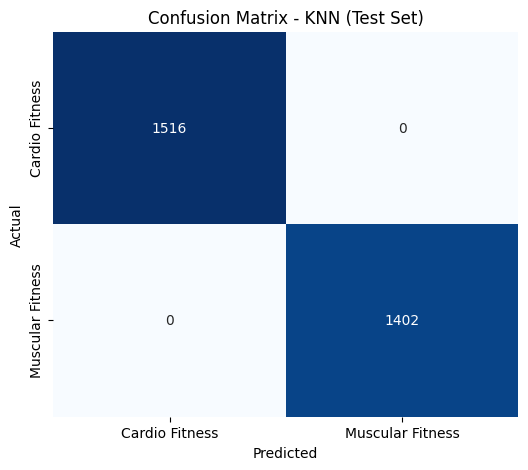

In [12]:
print("\nMengevaluasi model di Test Set")

y_pred = knn.predict(X_test)

# Evaluasi
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
report = classification_report(y_test, y_pred, target_names=le_target.classes_)
cm = confusion_matrix(y_test, y_pred)

print(f"\n Hasil Evaluasi KNN (k=5)")
print(f"Akurasi  : {accuracy:.4f}")
print(f"Presisi  : {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")
print("\nClassification Report:\n", report)

# Tampilkan Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
           xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.title('Confusion Matrix - KNN (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Persiapan Content Based Filtering

/tmp/ipython-input-2459768395.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ex_counts.values, y=ex_counts.index, palette='viridis')


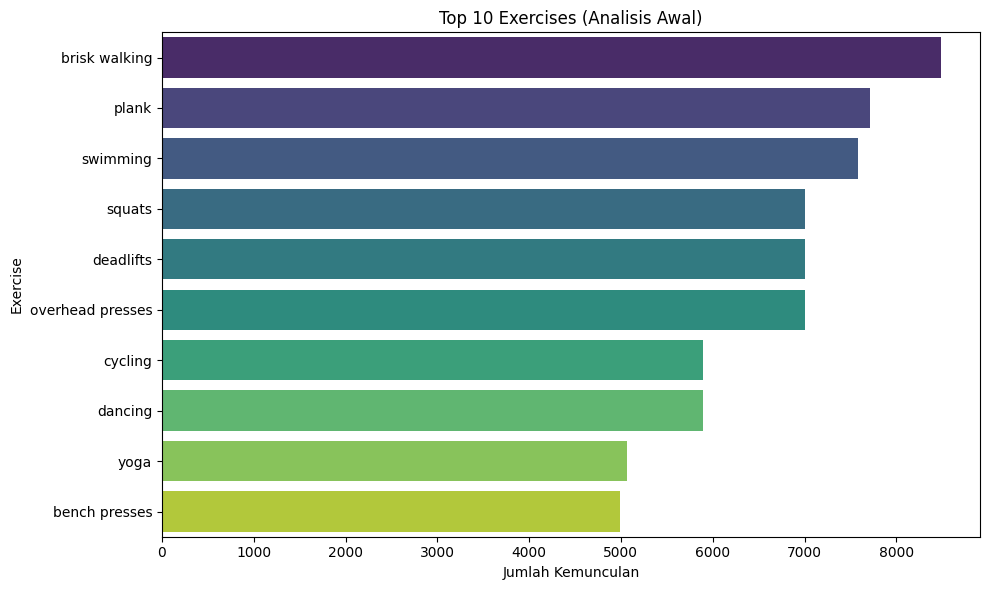

Total exercise unik (analisis awal): 68
Jenis exercises unik:  ['Squats, deadlifts, bench presses, and overhead presses, lunges, push up, Squat, Bench press, push-up, Deadlift, kettlebell swing, Pull-up, lat pull-down, Plank, side-plank'
 'Squats, deadlifts, bench presses, and overhead presses, Bodyweight squat, Push-up, Dumbbell deadlift, Pull-up, lat pull-down, Plank, side plank'
 'Squats, yoga, deadlifts, bench presses, and overhead presses, Barbell squat, dumbbell squat, Dumbbell bench press, Deadlift, Assisted pull-up, lat pull-down, Plank, Russian twist'
 'Squats, yoga, cycling, dumbbell), Dumbbell bench press, Deadlift, Pull-up, lat pull-down, plank'
 'Squats, deadlifts, bench presses, and overhead presses, Squat, Bench press, push-up, Deadlift, kettlebell swing, Pull-up, lat pull-down, Plank, side-plank'
 'Squats, yoga, deadlifts, bench presses, and overhead presses, dumbbell), Dumbbell bench press, Deadlift, Pull-up, lat pull-down, plank'
 'Squats, deadlifts, bench presses, an

In [13]:
# Analisis Variabel Exercises

exercises = df['Exercises'].dropna()

ex_clean_analysis = exercises.str.replace(r'\band\b|\bor\b', ',', regex=True)
ex_split_analysis = ex_clean_analysis.str.split(',').explode().str.strip().str.lower().str.replace(r'\.$', '', regex=True)
ex_split_analysis = ex_split_analysis[ex_split_analysis != ""]

ex_counts = ex_split_analysis.value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=ex_counts.values, y=ex_counts.index, palette='viridis')
plt.title('Top 10 Exercises (Analisis Awal)')
plt.xlabel('Jumlah Kemunculan')
plt.ylabel('Exercise')
plt.tight_layout()
plt.show()
print(f"Total exercise unik (analisis awal): {ex_split_analysis.nunique()}")
print("Jenis exercises unik: ", df["Exercises"].unique())

/tmp/ipython-input-1209144429.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=eq_counts.values, y=eq_counts.index, palette='viridis')


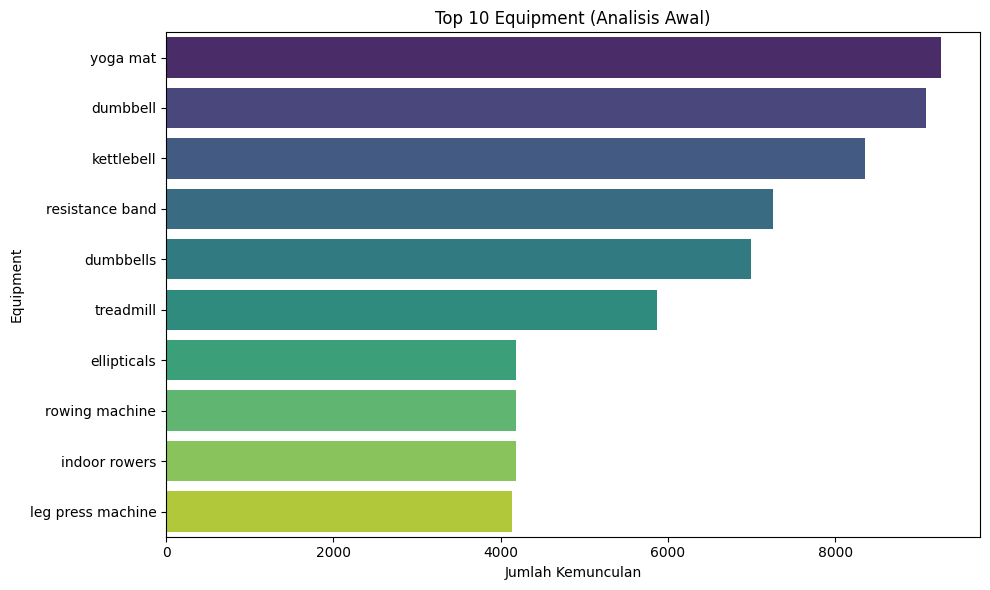

Total equipment unik: 43
Jenis equipment unik:  ['Dumbbells and barbells, Dumbbell, Flat bench, Pull-up bar, resistance band, Kettlebell, Yoga mat'
 'Light athletic shoes, resistance bands, and light dumbbells., Dumbbell, Pull-up bar, resistance band, Yoga mat, Kettlebell, strap'
 'Dumbbells, barbells and Blood glucose monitor, Barbell, Dumbbell, Pull-up bar, Lat pull-down machine, Kettlebell, Yoga mat, medicine ball'
 'Light athletic shoes, resistance bands, light dumbbells and a Blood glucose monitor., Dumbbell, Pull-up bar, lat pull-down, Yoga mat, Kettlebell'
 'Dumbbells and barbells, Barbell, Dumbbell, Flat bench, bench, Pull-up bar, lat pull-down machine, Yoga mat'
 'Light athletic shoes, resistance bands, and light dumbbells., Dumbbell, Pull-up bar, lat pull-down, Yoga mat, Kettlebell'
 'Dumbbells, barbells and Blood glucose monitor, Barbell, Dumbbell, Pull-up bar, lat pull-down, Kettlebell, Yoga mat, medicine ball'
 'Light athletic shoes, resistance bands, light dumbbells and a

In [14]:
# Analisis Variabel Equipment

equipment = df['Equipment'].dropna()

eq_clean_analysis = equipment.str.replace(r'\band\b|\bor\b|[.;]', ',', regex=True)
eq_split_analysis = eq_clean_analysis.str.split(',').explode().str.strip().str.lower()
eq_split_analysis = eq_split_analysis[eq_split_analysis != ""].replace({'a blood glucose monitor': 'blood glucose monitor', 'treadmills': 'treadmill'})

eq_counts = eq_split_analysis.value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=eq_counts.values, y=eq_counts.index, palette='viridis')
plt.title('Top 10 Equipment (Analisis Awal)')
plt.xlabel('Jumlah Kemunculan')
plt.ylabel('Equipment')
plt.tight_layout()
plt.show()
print(f"Total equipment unik: {eq_split_analysis.nunique()}")
print("Jenis equipment unik: ", df["Equipment"].unique())

## Data Preparation


In [15]:
# Ambil kolom yang relevan
preparation = df[['Hypertension', 'Diabetes', 'Fitness Type', 'Level', 'Fitness Goal', 'Sex', 'Age Group', 'Exercises', 'Equipment', 'Diet']].copy()

In [16]:
# Normalisasi Data

EXERCISE_NORM_MAP = {
    'Squats': 'Squat',
    'Barbell Back-Squat': 'Barbell Back Squat',
    'Barbell Squat': 'Barbell Back Squat',
    'Bench Presses': 'Bench Press',
    'Push-Up': 'Push Up',
    'Side-Plank': 'Side Plank',
    'Wall-Plank': 'Wall Plank',
    'Wall-Squat': 'Wall Squat',
    'Lat Pull-Down Asistensi': 'Assisted Lat Pull-Down',
    'Pull-Up Asistensi': 'Assisted Pull-Up',
    'Stationary Bikes': 'Stationary Bike',
    'Dancing': 'Cardio Dance',
    'Cycling': 'Outdoor Cycling',
    'Treadmill Inclinen': 'Treadmill',
    'Treadmill Incline': 'Treadmill',
    'Incline Treadmill': 'Treadmill',
    'Dumbbell Bench Press': 'Bench Press',
    'Dumbbell Chest Press': 'Chest Press',
    'Dumbbell Deadlift': 'Deadlift',
    'Dumbbell Incline Press': 'Chest Press',
    'Dumbbell Press': 'Chest Press',
    'Dumbbell': '',
    'Bodyweight': 'Squat',
    'Bodyweight Squat': 'Squat',
    'Deadlifts': 'Deadlift',
    'Machine': ''
}

EQUIPMENT_NORM_MAP = {
    'Barbells': 'Barbell',
    'Barbell Squat Rack': 'Squat Rack',
    'Dumbbells': 'Dumbbell',
    'Light Dumbbells': 'Dumbbell',
    'Resistance Bands': 'Resistance Band',
    'Treadmills': 'Treadmill machine',
    'Band Row': 'Resistance Band',
    'Chest Press': 'Chest Press Machine',
    'Ellipticals': 'Ellipticals Machine',
    'Leg Press': 'Leg Press Machine',
    'Seated Row': 'Seated Row Machine',
    'Wall Plank Mat Setup': 'Yoga Mat',
    'Leg Extension': 'Leg Extension Machine',
    'Leg Press Machine': 'Leg Press Machine',
    'Cable Row': 'Cable Row Machine',
    'Lat Pull-Down': 'Lat Pull-Down Machine',
    'Equipment Required': ''
}

In [17]:
# fungsi cleaning text

def clean_items(text, normalization_map):
    if not isinstance(text, str):
        return []

    # Pre-cleaning typo spesifik
    text = text.replace('Resistance Bandyoga Mat', 'Resistance Band | Yoga Mat')
    text = text.replace('Leg Extension & Leg Curl Machine', 'Leg Extension Machine | Leg Curl Machine')

    text = text.replace("(", "").replace(")", "").replace(";", "|").replace("&", "|")
    text = text.replace(" and ", "|").replace(" or ", "|").replace(",", "|")

    # Split kata dan bersihkan whitespace
    items = [item.strip() for item in text.split('|') if item.strip()]

    # Normalisasi dan Finalisasi per item
    cleaned_list = []
    for item in items:
        # Hapus artikel di depan
        item_lower_check = item.lower()
        if item_lower_check.startswith("a "): item = item[2:].strip()
        elif item_lower_check.startswith("an "): item = item[3:].strip()
        elif item_lower_check.startswith("and "): item = item[4:].strip()
        elif item_lower_check.startswith("or "): item = item[3:].strip()

        # Hapus karakter non-alfanumerik di belakang
        item = re.sub(r'[^\w\s\-]+$', '', item).strip()

        # Selalu konversi ke Title Case sebelum mapping
        item = item.title()

        if item in normalization_map:
            item = normalization_map[item]

        if item and item.lower() not in ["and", "or"]:
            cleaned_list.append(item)

    # Hapus duplikat setelah normalisasi
    return list(dict.fromkeys(cleaned_list))

In [18]:
# Membersihkan item dalam series
def normalize_text_column(text_col_series, norm_map):

    def clean_and_join(text):
        if not isinstance(text, str): return text
        items = clean_items(text, norm_map)
        return ', '.join(items) if items else text
    return text_col_series.apply(clean_and_join)

# String Diet Baru berdasarkan masukan Ahli Gizi (dengan acuan Tumpengku - Kemenkes)
TUMPENG_GIZI_DIET_STRING = (
    "Karbohidrat: (Nasi, Kentang, Roti Gandum, Jagung, Singkong, Ubi); "
    "Mineral & Serat: (Bayam, Kangkung, Wortel, Tomat, Brokoli, Jeruk, Apel, Pisang, Pepaya); "
    "Protein: (Tahu, Tempe, Kacang-kacangan, Ikan, Ayam Tanpa Kulit, Telur, Daging Tanpa Lemak, Susu Rendah Lemak)"
)

# Mengganti string diet lama dengan string Tumpeng Gizi standar
def replace_with_tumpeng_gizi(original_diet_string):
    return TUMPENG_GIZI_DIET_STRING

In [19]:
print("Menormalisasi item individual di 'Exercises'")
preparation['Exercises'] = normalize_text_column(preparation['Exercises'], EXERCISE_NORM_MAP)

print("\nMenormalisasi item individual di 'Equipment'")
preparation['Equipment'] = normalize_text_column(preparation['Equipment'], EQUIPMENT_NORM_MAP)

# Ganti semua Diet dengan Tumpeng Gizi
print("\nMengganti semua data 'Diet' dengan standar Tumpeng Gizi")
preparation['Diet'] = preparation['Diet'].apply(replace_with_tumpeng_gizi)

Menormalisasi item individual di 'Exercises'

Menormalisasi item individual di 'Equipment'

Mengganti semua data 'Diet' dengan standar Tumpeng Gizi


In [20]:
print("\nContoh data 'preparation' setelah cleaning data:")

print(preparation.head())


Contoh data 'preparation' setelah cleaning data:
  Hypertension Diabetes      Fitness Type        Level Fitness Goal   Sex  \
0           No       No  Muscular Fitness  Underweight  Weight Gain  Male   
1          Yes       No  Muscular Fitness  Underweight  Weight Gain  Male   
2           No      Yes  Muscular Fitness  Underweight  Weight Gain  Male   
3          Yes      Yes  Muscular Fitness  Underweight  Weight Gain  Male   
4           No       No  Muscular Fitness  Underweight  Weight Gain  Male   

  Age Group                                          Exercises  \
0     18-25  Squat, Deadlift, Bench Press, Overhead Presses...   
1     18-25  Squat, Deadlift, Bench Press, Overhead Presses...   
2     18-25  Squat, Yoga, Deadlift, Bench Press, Overhead P...   
3     18-25  Squat, Yoga, Outdoor Cycling, Bench Press, Dea...   
4     18-25  Squat, Deadlift, Bench Press, Overhead Presses...   

                                           Equipment  \
0  Dumbbell, Barbell, Flat Bench, 

In [21]:
# Buat Kolom 'content'
preparation['content'] = (
preparation['Exercises'].fillna('') + ' ' +
preparation['Equipment'].fillna('') + ' ' +
preparation['Diet'].fillna('')
).str.strip()

# TF IDF

In [22]:
# Hitung TF-IDF
tf = TfidfVectorizer(stop_words='english')

# Fit vectorizer ke data bersih
tfidf_matrix = tf.fit_transform(preparation['content'])
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

TF-IDF matrix shape: (14589, 112)


In [23]:
# Visualisasi Perhitungan Dataframe TF IDF dengan Dense Matrix
tfidf_matrix_dense = tfidf_matrix.todense()

pd.DataFrame(
    tfidf_matrix_dense,
    columns=tf.get_feature_names_out(),
    index=preparation.index
).sample(22, axis=1).sample(10, axis=0)

,apel,pisang,lat,crunch,jagung,treadmill,rendah,susu,extension,incline,...,tempe,kacang,seated,chair,monitor,walk,singkong,strap,rowers,setup
3559,0.056340,0.056340,0.266730,0.0,0.056340,0.000000,0.056340,0.056340,0.0,0.0,...,0.056340,0.056340,0.000000,0.000000,0.138785,0.000000,0.056340,0.0,0.000000,0.0
4986,0.081311,0.081311,0.000000,0.0,0.081311,0.297138,0.081311,0.081311,0.0,0.0,...,0.081311,0.081311,0.000000,0.000000,0.000000,0.000000,0.081311,0.0,0.182816,0.0
12804,0.078295,0.078295,0.000000,0.0,0.078295,0.000000,0.078295,0.078295,0.0,0.0,...,0.078295,0.078295,0.404482,0.000000,0.000000,0.000000,0.078295,0.0,0.000000,0.0
7813,0.082189,0.082189,0.000000,0.0,0.082189,0.000000,0.082189,0.082189,0.0,0.0,...,0.082189,0.082189,0.212300,0.000000,0.000000,0.265989,0.082189,0.0,0.000000,0.0
5011,0.056628,0.056628,0.268094,0.0,0.056628,0.000000,0.056628,0.056628,0.0,0.0,...,0.056628,0.056628,0.000000,0.000000,0.000000,0.000000,0.056628,0.0,0.000000,0.0
10669,0.079296,0.079296,0.000000,0.0,0.079296,0.000000,0.079296,0.079296,0.0,0.0,...,0.079296,0.079296,0.409653,0.000000,0.000000,0.000000,0.079296,0.0,0.000000,0.0
4452,0.072887,0.072887,0.000000,0.0,0.072887,0.000000,0.072887,0.072887,0.0,0.0,...,0.072887,0.072887,0.000000,0.228933,0.179546,0.000000,0.072887,0.0,0.000000,0.0
14324,0.061407,0.061407,0.000000,0.0,0.061407,0.112201,0.061407,0.061407,0.0,0.0,...,0.061407,0.061407,0.158618,0.000000,0.000000,0.198731,0.061407,0.0,0.138065,0.0
7469,0.059907,0.059907,0.000000,0.0,0.059907,0.000000,0.059907,0.059907,0.0,0.0,...,0.059907,0.059907,0.154742,0.000000,0.000000,0.387751,0.059907,0.0,0.000000,0.0
7585,0.082189,0.082189,0.000000,0.0,0.082189,0.000000,0.082189,0.082189,0.0,0.0,...,0.082189,0.082189,0.212300,0.000000,0.000000,0.265989,0.082189,0.0,0.000000,0.0


# Cosine Similarity

In [24]:
# Menghitung Cosine Similarity Untuk Seluruh Item
cosine_sim = cosine_similarity(tfidf_matrix)

print(f"Cosine Similarity matrix shape: {cosine_sim.shape}")

Cosine Similarity matrix shape: (14589, 14589)


In [25]:
# Contoh Tampilan Cosine Sim Matrix
cosine_sim_df = pd.DataFrame(cosine_sim, index=preparation.index, columns=preparation.index)

print("\nContoh Cosine Similarity Matrix (5x5 sample):")
print(cosine_sim_df.sample(min(5, len(cosine_sim_df)), axis=1).sample(min(5, len(cosine_sim_df)), axis=0))


Contoh Cosine Similarity Matrix (5x5 sample):
          1450      3582      5070      10174     2393 
8696   0.292157  0.949137  0.254351  0.687406  1.000000
588    0.360352  0.265736  0.292895  0.317701  0.266423
2301   0.292157  0.949137  0.254351  0.687406  1.000000
11938  0.862229  0.508398  0.322917  0.344902  0.453442
9348   0.437286  0.342194  0.382796  0.409454  0.343589


In [26]:
# Menganalisis item unik dari dataframe 'preparation'

# Untuk Exercises
all_exercises = set()

for item_list in preparation['Exercises'].apply(lambda x: clean_items(x, EXERCISE_NORM_MAP)):
    all_exercises.update(item_list)

print("Unique Exercises")
print(sorted(list(all_exercises)))
print(f"Total unique exercises: {len(all_exercises)}")


# Untuk Equipment
all_equipment = set()

for item_list in preparation['Equipment'].apply(lambda x: clean_items(x, EQUIPMENT_NORM_MAP)):
    all_equipment.update(item_list)

print("\nUnique Equipment")
print(sorted(list(all_equipment)))
print(f"Total unique equipment: {len(all_equipment)}")

Unique Exercises
['Aqua Jogging', 'Assisted Lat Pull-Down', 'Assisted Pull-Up', 'Band Row', 'Barbell Back Squat', 'Bench Press', 'Brisk Walking', 'Cable Row', 'Cardio Dance', 'Chair Squat', 'Chest Press', 'Deadlift', 'Dumbbell Row', 'Dumbbell Squat', 'Elliptical', 'Farmers Walk', 'Front Plank', 'Goblet Squat', 'Hip Bridge', 'Hip Hinge', 'Kettlebell Swing', 'Lat Pull-Down', 'Leg Curl', 'Leg Extension', 'Leg Press', 'Lunges', 'Outdoor Cycling', 'Overhead Presses', 'Plank', 'Pull-Up', 'Push Up', 'Resistance Band Row', 'Reverse Crunch', 'Romanian Deadlift', 'Running', 'Russian Twist', 'Seated Cable Row', 'Seated Row', 'Side Plank', 'Squat', 'Stair Climber', 'Stationary Bike', 'Swimming', 'Treadmill', 'Walking', 'Wall Plank', 'Wall Squat', 'Yoga']
Total unique exercises: 48

Unique Equipment
['Assisted Pull-Up Machine', 'Barbell', 'Bench', 'Blood Glucose Monitor', 'Box', 'Cable Row Machine', 'Chest Press Machine', 'Dumbbell', 'Ellipticals Machine', 'Farmer Walk Handles', 'Flat Bench', 'Incl

# Fungsi Content Based Filtering (CBF)

In [27]:
# Fungsi Rekomendasi CBF (Logika Cosine Sim + Mode)

# Memberikan rekomendasi CBF: Filter -> Cari Top N Mirip -> Voting Mode.
def cbf_recommendations_with_cosine(fitness_type, hypertension, diabetes, level, goal, sex, age_group, top_n_similar=5):

    global preparation, cosine_sim
    if 'preparation' not in globals() or 'cosine_sim' not in globals():
         return {"Error": "Data 'preparation' atau 'cosine_sim' belum dihitung."}

    hypertension_clean = str(hypertension).strip().title()
    diabetes_clean = str(diabetes).strip().title()
    level_clean = str(level).strip().title()
    goal_clean = str(goal).strip().title()
    sex_clean = str(sex).strip().title()
    age_group_clean = str(age_group).strip()
    print(f"\n Mencari filter spesifik...")

    # Base query (Kondisi Kesehatan + Tipe Fitness)
    base_query = (preparation['Fitness Type'] == fitness_type) & \
                 (preparation['Hypertension'].str.strip().str.title() == hypertension_clean) & \
                 (preparation['Diabetes'].str.strip().str.title() == diabetes_clean)

    print(f"   - Mencoba: Age Group, Level, Goal, Sex...")

    # Filter Spesifik
    filtered_df = preparation[
        base_query &
        (preparation['Age Group'].str.strip() == age_group_clean) &
        (preparation['Level'].str.strip().str.title() == level_clean) &
        (preparation['Fitness Goal'].str.strip().str.title() == goal_clean) &
        (preparation['Sex'].str.strip().str.title() == sex_clean)
    ].copy()

    # Fallback: Buang 'Age Group'
    if filtered_df.empty:
        print(f"   - Gagal. Fallback: Mencoba tanpa 'Age Group'...")
        filtered_df = preparation[
            base_query &
            (preparation['Level'].str.strip().str.title() == level_clean) &
            (preparation['Fitness Goal'].str.strip().str.title() == goal_clean) &
            (preparation['Sex'].str.strip().str.title() == sex_clean)
        ].copy()

    # Fallback: Buang 'Sex'
    if filtered_df.empty:
        print(f"   - Gagal. Fallback: Mencoba tanpa 'Sex' & 'Age Group'...")
        filtered_df = preparation[
            base_query &
            (preparation['Level'].str.strip().str.title() == level_clean) &
            (preparation['Fitness Goal'].str.strip().str.title() == goal_clean)
        ].copy()

    # Fallback: Buang 'Level' & 'Goal'
    if filtered_df.empty:
        print(f"   - Gagal. Fallback: Mencoba tanpa 'Level' & 'Goal'...")
        filtered_df = preparation[base_query].copy()

    # Fallback: Cuma 'Fitness Type'
    if filtered_df.empty:
        print(f"   - Gagal. Fallback: Mencoba HANYA 'Fitness Type'...")
        filtered_df = preparation[preparation['Fitness Type'] == fitness_type].copy()
        if filtered_df.empty:
            return {"Error": f"Tidak ada data untuk Tipe Fitness: {fitness_type}."}

    if len(filtered_df) < top_n_similar:
        print(f"Warning: Hanya ditemukan {len(filtered_df)} data cocok, kurang dari top_n={top_n_similar}.")
        top_n_similar = len(filtered_df)

    if len(filtered_df) == 0:
         return {"Error": "Tidak ada data cocok sama sekali."}

    # Hitung rata-rata similarity score dan ambil 5 tertinggi

    # Ambil index data yang lolos filter
    filtered_indices = filtered_df.index.tolist()

    # Slice matrix cosine similarity hanya untuk data yang lolos filter
    sim_matrix_filtered = cosine_sim[filtered_indices, :][:, filtered_indices]

    # Hitung rata-rata similarity
    avg_sim_scores = sim_matrix_filtered.mean(axis=1)
    sim_scores_series = pd.Series(avg_sim_scores, index=filtered_indices)

    # Ambil Top N (default 5) dengan score tertinggi
    top_n_indices = sim_scores_series.nlargest(top_n_similar).index.tolist()
    topN_df = preparation.loc[top_n_indices]

    print(f"\nTop {top_n_similar} item paling mirip (berdasarkan konten):")
    print(topN_df[['Exercises', 'Equipment', 'Diet']])

    try:
      # Mengambil nilai modus (yang paling sering muncul) dari 5 kandidat teratas
        final_exercise = topN_df['Exercises'].mode()[0]
        final_equipment = topN_df['Equipment'].mode()[0]
        final_diet = topN_df['Diet'].mode()[0]
    except Exception as e: return {"Error": f"Gagal voting: {e}"}

    return {'Exercises': final_exercise, 'Equipment': final_equipment, 'Diet': final_diet}

In [28]:
# CONTOH TEST (UNDERWEIGHT)
print("\nContoh hasil rekomendasi CBF:")
recommendations_cosine = cbf_recommendations_with_cosine(
  fitness_type="Muscular Fitness",
  hypertension="No",
  diabetes="No",
  level="Underweight",
  goal="Weight Gain",
  sex="Female",
  age_group="26-35",
  top_n_similar=5
  )

print("\nHasil Rekomendasi:")
print(recommendations_cosine)


Contoh hasil rekomendasi CBF:

 Mencari filter spesifik...
   - Mencoba: Age Group, Level, Goal, Sex...

Top 5 item paling mirip (berdasarkan konten):
                                              Exercises  \
1572  Squat, Deadlift, Bench Press, Overhead Presses...   
1605  Squat, Deadlift, Bench Press, Overhead Presses...   
1637  Squat, Deadlift, Bench Press, Overhead Presses...   
1669  Squat, Deadlift, Bench Press, Overhead Presses...   
1701  Squat, Deadlift, Bench Press, Overhead Presses...   

                                              Equipment  \
1572  Dumbbell, Barbell, Flat Bench, Pull-Up Bar, Re...   
1605  Dumbbell, Barbell, Flat Bench, Pull-Up Bar, Re...   
1637  Dumbbell, Barbell, Flat Bench, Pull-Up Bar, Re...   
1669  Dumbbell, Barbell, Flat Bench, Pull-Up Bar, Re...   
1701  Dumbbell, Barbell, Flat Bench, Pull-Up Bar, Re...   

                                                   Diet  
1572  Karbohidrat: (Nasi, Kentang, Roti Gandum, Jagu...  
1605  Karbohidrat: (Na

In [29]:
# CONTOH TEST (OVERWEIGHT)
print("\nContoh hasil rekomendasi CBF:")
recommendations_cosine = cbf_recommendations_with_cosine(
  fitness_type="Cardio Fitness",
  hypertension="No",
  diabetes="No",
  level="Overweight",
  goal="Weight Loss",
  sex="Male",
  age_group="26-35",
  top_n_similar=5
  )

print("\nHasil Rekomendasi:")
print(recommendations_cosine)


Contoh hasil rekomendasi CBF:

 Mencari filter spesifik...
   - Mencoba: Age Group, Level, Goal, Sex...

Top 5 item paling mirip (berdasarkan konten):
                                              Exercises  \
276   Brisk Walking, Outdoor Cycling, Swimming, Runn...   
336   Brisk Walking, Outdoor Cycling, Swimming, Runn...   
404   Brisk Walking, Outdoor Cycling, Swimming, Runn...   
1649  Brisk Walking, Outdoor Cycling, Swimming, Runn...   
1681  Brisk Walking, Outdoor Cycling, Swimming, Runn...   

                                              Equipment  \
276   Ellipticals Machine, Indoor Rowers, Treadmill ...   
336   Ellipticals Machine, Indoor Rowers, Treadmill ...   
404   Ellipticals Machine, Indoor Rowers, Treadmill ...   
1649  Ellipticals Machine, Indoor Rowers, Treadmill ...   
1681  Ellipticals Machine, Indoor Rowers, Treadmill ...   

                                                   Diet  
276   Karbohidrat: (Nasi, Kentang, Roti Gandum, Jagu...  
336   Karbohidrat: (Na

In [30]:
# CONTOH TEST (OVERWEIGHT + WEIGHT GAIN)
print("\nContoh hasil rekomendasi CBF:")
recommendations_cosine = cbf_recommendations_with_cosine(
  fitness_type="Muscular Fitness",
  hypertension="No",
  diabetes="No",
  level="Overweight",
  goal="Weight Gain",
  sex="Female",
  age_group="26-35",
  top_n_similar=5
  )

print("\nHasil Rekomendasi:")
print(recommendations_cosine)


Contoh hasil rekomendasi CBF:

 Mencari filter spesifik...
   - Mencoba: Age Group, Level, Goal, Sex...
   - Gagal. Fallback: Mencoba tanpa 'Age Group'...
   - Gagal. Fallback: Mencoba tanpa 'Sex' & 'Age Group'...
   - Gagal. Fallback: Mencoba tanpa 'Level' & 'Goal'...

Top 5 item paling mirip (berdasarkan konten):
                                             Exercises  \
416  Squat, Deadlift, Bench Press, Overhead Presses...   
420  Squat, Deadlift, Bench Press, Overhead Presses...   
448  Squat, Deadlift, Bench Press, Overhead Presses...   
452  Squat, Deadlift, Bench Press, Overhead Presses...   
480  Squat, Deadlift, Bench Press, Overhead Presses...   

                                             Equipment  \
416  Dumbbell, Barbell, Bench, Cable Row Machine, K...   
420  Dumbbell, Barbell, Bench, Cable Row Machine, K...   
448  Dumbbell, Barbell, Bench, Cable Row Machine, K...   
452  Dumbbell, Barbell, Bench, Cable Row Machine, K...   
480  Dumbbell, Barbell, Bench, Cable Row Ma

In [31]:
# CONTOH TEST (UNDERWEIGHT + WEIGHT LOSS)
print("\nContoh hasil rekomendasi CBF:")
recommendations_cosine = cbf_recommendations_with_cosine(
  fitness_type="Cardio Fitness",
  hypertension="No",
  diabetes="No",
  level="Underweight",
  goal="Weight Loss",
  sex="Female",
  age_group="26-35",
  top_n_similar=5
  )

print("\nHasil Rekomendasi:")
print(recommendations_cosine)


Contoh hasil rekomendasi CBF:

 Mencari filter spesifik...
   - Mencoba: Age Group, Level, Goal, Sex...
   - Gagal. Fallback: Mencoba tanpa 'Age Group'...
   - Gagal. Fallback: Mencoba tanpa 'Sex' & 'Age Group'...
   - Gagal. Fallback: Mencoba tanpa 'Level' & 'Goal'...

Top 5 item paling mirip (berdasarkan konten):
                                              Exercises  \
1080  Brisk Walking, Outdoor Cycling, Swimming, Runn...   
1084  Brisk Walking, Outdoor Cycling, Swimming, Runn...   
1112  Brisk Walking, Outdoor Cycling, Swimming, Runn...   
1116  Brisk Walking, Outdoor Cycling, Swimming, Runn...   
1144  Brisk Walking, Outdoor Cycling, Swimming, Runn...   

                                              Equipment  \
1080  Ellipticals Machine, Indoor Rowers, Treadmill ...   
1084  Ellipticals Machine, Indoor Rowers, Treadmill ...   
1112  Ellipticals Machine, Indoor Rowers, Treadmill ...   
1116  Ellipticals Machine, Indoor Rowers, Treadmill ...   
1144  Ellipticals Machine, Indoo

In [38]:
# CONTOH TEST (NORMAL + WEIGHT LOSS)
print("\nContoh hasil rekomendasi CBF:")
recommendations_cosine = cbf_recommendations_with_cosine(
  fitness_type="Cardio Fitness",
  hypertension="No",
  diabetes="No",
  level="Normal",
  goal="Weight Loss",
  sex="Female",
  age_group="26-35",
  top_n_similar=5
  )

print("\nHasil Rekomendasi:")
print(recommendations_cosine)


Contoh hasil rekomendasi CBF:

 Mencari filter spesifik...
   - Mencoba: Age Group, Level, Goal, Sex...
   - Gagal. Fallback: Mencoba tanpa 'Age Group'...
   - Gagal. Fallback: Mencoba tanpa 'Sex' & 'Age Group'...
   - Gagal. Fallback: Mencoba tanpa 'Level' & 'Goal'...

Top 5 item paling mirip (berdasarkan konten):
                                              Exercises  \
1080  Brisk Walking, Outdoor Cycling, Swimming, Runn...   
1084  Brisk Walking, Outdoor Cycling, Swimming, Runn...   
1112  Brisk Walking, Outdoor Cycling, Swimming, Runn...   
1116  Brisk Walking, Outdoor Cycling, Swimming, Runn...   
1144  Brisk Walking, Outdoor Cycling, Swimming, Runn...   

                                              Equipment  \
1080  Ellipticals Machine, Indoor Rowers, Treadmill ...   
1084  Ellipticals Machine, Indoor Rowers, Treadmill ...   
1112  Ellipticals Machine, Indoor Rowers, Treadmill ...   
1116  Ellipticals Machine, Indoor Rowers, Treadmill ...   
1144  Ellipticals Machine, Indoo

# Evaluasi Content Based Filtering

In [32]:
# Evaluasi CBF dengan Precision@k & Recall@k

def calculate_average_metrics_at_k(k_values, n_samples=None):

    global preparation, cosine_sim, EXERCISE_NORM_MAP, EQUIPMENT_NORM_MAP

    if 'preparation' not in globals() or 'cosine_sim' not in globals():
         print("ERROR: Data 'preparation' atau 'cosine_sim' belum dihitung.")
         return {}, {}
    if 'EXERCISE_NORM_MAP' not in globals() or 'EQUIPMENT_NORM_MAP' not in globals():
         print("ERROR: Normalization maps (EXERCISE_NORM_MAP / EQUIPMENT_NORM_MAP) tidak ditemukan.")
         return {}, {}

    results_precision = {k: [] for k in k_values}
    results_recall = {k: [] for k in k_values}

    if n_samples and n_samples < len(preparation):
        eval_indices = preparation.sample(n_samples, random_state=42).index
        print(f"Mengevaluasi {n_samples} sampel data...")
    else:
        eval_indices = preparation.index
        print(f"Mengevaluasi semua {len(preparation)} data...")

    for i in eval_indices:
        try:
            gt_exercises = set(clean_items(preparation.loc[i, 'Exercises'], EXERCISE_NORM_MAP))
            gt_equipment = set(clean_items(preparation.loc[i, 'Equipment'], EQUIPMENT_NORM_MAP))
            ground_truth_items = gt_exercises.union(gt_equipment)
            if not ground_truth_items: continue
        except Exception as e:
            print(f"Warning: Gagal memproses ground truth baris {i}: {e}")
            continue

        current_ft = preparation.loc[i, 'Fitness Type']
        current_h_clean = str(preparation.loc[i, 'Hypertension']).strip().title()
        current_d_clean = str(preparation.loc[i, 'Diabetes']).strip().title()
        current_level_clean = str(preparation.loc[i, 'Level']).strip().title()
        current_goal_clean = str(preparation.loc[i, 'Fitness Goal']).strip().title()
        current_sex_clean = str(preparation.loc[i, 'Sex']).strip().title()
        current_age_group_clean = str(preparation.loc[i, 'Age Group']).strip()

        base_query = (preparation['Fitness Type'] == current_ft) & \
                     (preparation['Hypertension'].str.strip().str.title() == current_h_clean) & \
                     (preparation['Diabetes'].str.strip().str.title() == current_d_clean)

        # Coba Paling Spesifik
        filtered_df = preparation[
            base_query &
            (preparation['Age Group'].str.strip() == current_age_group_clean) &
            (preparation['Level'].str.strip().str.title() == current_level_clean) &
            (preparation['Fitness Goal'].str.strip().str.title() == current_goal_clean) &
            (preparation['Sex'].str.strip().str.title() == current_sex_clean)
        ].copy()

        # Fallback: Buang 'Age Group'
        if len(filtered_df) <= 1:
            filtered_df = preparation[
                base_query &
                (preparation['Level'].str.strip().str.title() == current_level_clean) &
                (preparation['Fitness Goal'].str.strip().str.title() == current_goal_clean) &
                (preparation['Sex'].str.strip().str.title() == current_sex_clean)
            ].copy()

        # Fallback: Buang 'Sex'
        if len(filtered_df) <= 1:
            filtered_df = preparation[
                base_query &
                (preparation['Level'].str.strip().str.title() == current_level_clean) &
                (preparation['Fitness Goal'].str.strip().str.title() == current_goal_clean)
            ].copy()

        # Fallback: Buang 'Level' & 'Goal'
        if len(filtered_df) <= 1:
            filtered_df = preparation[base_query].copy()

        # Fallback: Cuma 'Fitness Type'
        if len(filtered_df) <= 1:
            filtered_df = preparation[preparation['Fitness Type'] == current_ft].copy()

        if len(filtered_df) <= 1:
            continue

        filtered_indices = filtered_df.index.tolist()
        try:
            idx_in_filtered = filtered_indices.index(i)
        except ValueError:
            continue

        # top-k
        sim_scores_row = cosine_sim[filtered_indices, :][:, filtered_indices][idx_in_filtered]
        sim_series = pd.Series(sim_scores_row, index=filtered_indices).sort_values(ascending=False)

        for k in k_values:
            top_k_indices = sim_series[1:k+1].index.tolist()
            if not top_k_indices:
                 precision_at_k = 0.0
                 recall_at_k = 0.0
            else:
                recommended_items = set()
                top_k_df = preparation.loc[top_k_indices]
                combined_ex = ' | '.join(top_k_df['Exercises'].astype(str).tolist())
                combined_eq = ' | '.join(top_k_df['Equipment'].astype(str).tolist())

                recommended_items.update(clean_items(combined_ex, EXERCISE_NORM_MAP))
                recommended_items.update(clean_items(combined_eq, EQUIPMENT_NORM_MAP))

                hits = ground_truth_items.intersection(recommended_items)

                if len(recommended_items) == 0:
                    precision_at_k = 0.0
                else:
                    precision_at_k = len(hits) / len(recommended_items)

                recall_at_k = len(hits) / len(ground_truth_items)

            results_precision[k].append(precision_at_k)
            results_recall[k].append(recall_at_k)

    # Kalkulasi rata-rata
    avg_precision = {k: np.mean(v) if v else 0.0 for k, v in results_precision.items()}
    avg_recall = {k: np.mean(v) if v else 0.0 for k, v in results_recall.items()}

    return avg_precision, avg_recall

#  Evaluasi Precision@k
k_to_evaluate = [5, 10]

# Ambil dua value
avg_precision, avg_recall = calculate_average_metrics_at_k(k_values=k_to_evaluate, n_samples=100)

print("\nHasil Rata-rata Precision & Recall @k")

for k in k_to_evaluate:
  print(f"Precision@{k}: {avg_precision.get(k, 0.0):.4f}")
  print(f"Recall@{k}   : {avg_recall.get(k, 0.0):.4f}")

Mengevaluasi 100 sampel data...

Hasil Rata-rata Precision & Recall @k
Precision@5: 0.9917
Recall@5   : 0.9971
Precision@10: 0.9819
Recall@10   : 0.9971


# Menyimpan Model

In [33]:
# Simpan Model & Data

output_folder = "models"
import os
if not os.path.exists(output_folder):
  os.makedirs(output_folder)
  print(f"- Membuat folder '{output_folder}'.")

# Simpan KNN components
joblib.dump(knn, os.path.join(output_folder, "knn_model.pkl"))
joblib.dump(le_dict, os.path.join(output_folder, "label_encoders.pkl"))
joblib.dump(le_target, os.path.join(output_folder, "target_encoder.pkl"))
joblib.dump(scaler, os.path.join(output_folder, "scaler.pkl"))

# Simpan data 'preparation'
joblib.dump(preparation, os.path.join(output_folder, "preparation_data.pkl"))

# Simpan TF-IDF & Cosine Sim
joblib.dump(tf, os.path.join(output_folder, "tfidf_vectorizer.pkl"))
joblib.dump(cosine_sim, os.path.join(output_folder, "cosine_sim_matrix.pkl"))

- Membuat folder 'models'.


['models/cosine_sim_matrix.pkl']

# Inference

In [34]:
# Mendefinisikan fungsi untuk inference

def calculate_bmi(height_cm, weight_kg):
    if height_cm == 0: return 0
    height_m = height_cm / 100.0
    return weight_kg / (height_m ** 2)

def get_bmi_level(bmi):
    if bmi < 18.5: return "Underweight"
    elif 18.5 <= bmi < 24.9: return "Normal"
    elif 25.0 <= bmi < 29.9: return "Overweight"
    else: return "Obese"

def get_fitness_goal(level):
    if level in ["Underweight", "Normal"]: return "Weight Gain"
    elif level in ["Overweight", "Obese"]: return "Weight Loss"
    return None

def get_age_group(age):
    if 18 <= age <= 25: return "18-25"
    elif 26 <= age <= 35: return "26-35"
    elif 36 <= age <= 45: return "36-45"
    elif 46 <= age <= 55: return "46-55"
    else: return "56+"

def knn_predict_fitness_test(user_input_dict, model_folder="models"):
    try:
        knn_model = joblib.load(os.path.join(model_folder, "knn_model.pkl"))
        scaler = joblib.load(os.path.join(model_folder, "scaler.pkl"))
        le_dict = joblib.load(os.path.join(model_folder, "label_encoders.pkl"))
        le_target = joblib.load(os.path.join(model_folder, "target_encoder.pkl"))
        categorical_cols = ['Sex', 'Level', 'Fitness Goal', 'Age Group']
        numeric_cols = ['Age', 'Height', 'Weight', 'BMI']
    except FileNotFoundError: return "Error: File model KNN tidak ditemukan"
    ordered_cols = ['Sex', 'Age', 'Height', 'Weight', 'BMI', 'Level', 'Fitness Goal', 'Age Group']
    new_user = pd.DataFrame([user_input_dict])
    try:
        for col in categorical_cols:
            new_user.loc[:, col] = le_dict[col].transform(new_user[col])
    except Exception as e: return f"Error encoding: {e}."
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        new_user.loc[:, numeric_cols] = scaler.transform(new_user[numeric_cols])
    new_user = new_user[ordered_cols]
    pred_class = knn_model.predict(new_user)[0]
    return le_target.inverse_transform([pred_class])[0]

def cbf_recommendations_with_cosine_test(fitness_type, hypertension, diabetes, level, goal, sex, age_group, top_n_similar=5, model_folder="models"):
    try:
        preparation_loaded = joblib.load(os.path.join(model_folder, "preparation_data.pkl"))
        cosine_sim_loaded = joblib.load(os.path.join(model_folder, "cosine_sim_matrix.pkl"))
    except FileNotFoundError:
        return {"Error": "File model (preparation/cosine_sim) tidak ditemukan"}

    hypertension_clean = str(hypertension).strip().title()
    diabetes_clean = str(diabetes).strip().title()
    level_clean = str(level).strip().title()
    goal_clean = str(goal).strip().title()
    sex_clean = str(sex).strip().title()
    age_group_clean = str(age_group).strip()

    print(f"\n Mencari filter spesifik...")

    base_query = (preparation_loaded['Fitness Type'] == fitness_type) & \
                 (preparation_loaded['Hypertension'].str.strip().str.title() == hypertension_clean) & \
                 (preparation_loaded['Diabetes'].str.strip().str.title() == diabetes_clean)

    # 1. Coba Paling Spesifik (Lengkap)
    print(f"   - Mencoba: Age Group, Level, Goal, Sex...")
    filtered_df = preparation_loaded[
        base_query &
        (preparation_loaded['Age Group'].str.strip() == age_group_clean) &
        (preparation_loaded['Level'].str.strip().str.title() == level_clean) &
        (preparation_loaded['Fitness Goal'].str.strip().str.title() == goal_clean) &
        (preparation_loaded['Sex'].str.strip().str.title() == sex_clean)
    ].copy()

    # 2. Fallback: Buang 'Age Group'
    if filtered_df.empty:
        print(f"   - Gagal. Fallback: Mencoba tanpa 'Age Group'...")
        filtered_df = preparation_loaded[
            base_query &
            (preparation_loaded['Level'].str.strip().str.title() == level_clean) &
            (preparation_loaded['Fitness Goal'].str.strip().str.title() == goal_clean) &
            (preparation_loaded['Sex'].str.strip().str.title() == sex_clean)
        ].copy()

    # 3. Fallback: Buang 'Sex'
    if filtered_df.empty:
        print(f"   - Gagal. Fallback: Mencoba tanpa 'Sex' & 'Age Group'...")
        filtered_df = preparation_loaded[
            base_query &
            (preparation_loaded['Level'].str.strip().str.title() == level_clean) &
            (preparation_loaded['Fitness Goal'].str.strip().str.title() == goal_clean)
        ].copy()

    # 4. Fallback: Buang 'Level' & 'Goal'
    if filtered_df.empty:
        print(f"   - Gagal. Fallback: Mencoba tanpa 'Level' & 'Goal'...")
        filtered_df = preparation_loaded[base_query].copy()

    # 5. Fallback: Cuma 'Fitness Type'
    if filtered_df.empty:
        print(f"   - Gagal. Fallback: Mencoba HANYA 'Fitness Type'...")
        filtered_df = preparation_loaded[preparation_loaded['Fitness Type'] == fitness_type].copy()
        if filtered_df.empty:
            return {"Error": f"Tidak ada data untuk Tipe Fitness: {fitness_type}."}

    if len(filtered_df) < top_n_similar:
        print(f"\nWarning: Hanya ditemukan {len(filtered_df)} data cocok, kurang dari top_n={top_n_similar}.")
        top_n_similar = len(filtered_df)

    if len(filtered_df) == 0:
        return {"Error": "Tidak ada data cocok sama sekali."}

    filtered_indices = filtered_df.index.tolist()
    sim_matrix_filtered = cosine_sim_loaded[filtered_indices, :][:, filtered_indices]
    avg_sim_scores = sim_matrix_filtered.mean(axis=1)
    sim_scores_series = pd.Series(avg_sim_scores, index=filtered_indices)
    top_n_indices = sim_scores_series.nlargest(top_n_similar).index.tolist()
    topN_df = preparation_loaded.loc[top_n_indices]

    print(f"\nTop {top_n_similar} item paling mirip (berdasarkan konten):")
    print(topN_df[['Exercises', 'Equipment', 'Diet']])

    try:
        final_exercise = topN_df['Exercises'].mode()[0]
        final_equipment = topN_df['Equipment'].mode()[0]
        final_diet = topN_df['Diet'].mode()[0]
    except Exception as e:
        return {"Error": f"Gagal voting: {e}"}

    return {'Exercises': final_exercise, 'Equipment': final_equipment, 'Diet': final_diet}


def get_full_recommendation_test_cosine(sex, age, height_cm, weight_kg, hypertension, diabetes):
    print("1. Menerima Input Mentah")
    print(f"   Sex: {sex}, Age: {age}, Height: {height_cm}cm, Weight: {weight_kg}kg")
    print(f"   Hypertension: {hypertension}, Diabetes: {diabetes}")
    bmi = calculate_bmi(height_cm, weight_kg)
    print(f"\n2. Kalkulasi Turunan")
    print(f"   Calculated BMI: {bmi:.2f}")
    level = get_bmi_level(bmi)
    print(f"   Determined Level: {level}")
    goal = get_fitness_goal(level)
    print(f"   DetermGmbined Fitness Goal: {goal}")
    age_group = get_age_group(age)
    print(f"   Determined Age Group: {age_group}")

    knn_input = {"Sex": sex, "Age": age, "Height": height_cm, "Weight": weight_kg, "BMI": bmi, "Level": level, "Fitness Goal": goal, "Age Group": age_group} # <-- TAMBAH 'Age Group'
    print(f"\n3. Prediksi KNN (Fitness Type)")
    predicted_type = knn_predict_fitness_test(knn_input)
    if "Error" in str(predicted_type):
        print(f"   Error KNN: {predicted_type}")
        return
    print(f"   Predicted Fitness Type: {predicted_type}")
    print(f"\n4. Rekomendasi Detail (CBF dengan Cosine Sim)")

    cbf_result = cbf_recommendations_with_cosine_test(
        fitness_type=predicted_type,
        hypertension=hypertension,
        diabetes=diabetes,
        level=level,
        goal=goal,
        sex=sex,
        age_group=age_group,
        top_n_similar=5
    )
    print(f"\nHASIL REKOMENDASI FINAL")
    print(f"Level: {level} (Goal: {goal}) (Age: {age_group})")
    print(f"Tipe Fitness: {predicted_type}")
    print("---------------------------------")
    print(f"Exercises: {cbf_result.get('Exercises', 'N/A')}")
    print(f"Equipment: {cbf_result.get('Equipment', 'N/A')}")
    print(f"Diet: {cbf_result.get('Diet', 'N/A')}")

In [35]:
# Contoh Inference

print("CONTOH 1 (OVERWEIGHT)")
get_full_recommendation_test_cosine(sex="Male", age=25, height_cm=170, weight_kg=75, hypertension="No", diabetes="No")

CONTOH 1 (OVERWEIGHT)
1. Menerima Input Mentah
   Sex: Male, Age: 25, Height: 170cm, Weight: 75kg
   Hypertension: No, Diabetes: No

2. Kalkulasi Turunan
   Calculated BMI: 25.95
   Determined Level: Overweight
   DetermGmbined Fitness Goal: Weight Loss
   Determined Age Group: 18-25

3. Prediksi KNN (Fitness Type)
   Predicted Fitness Type: Cardio Fitness

4. Rekomendasi Detail (CBF dengan Cosine Sim)

 Mencari filter spesifik...
   - Mencoba: Age Group, Level, Goal, Sex...

Top 5 item paling mirip (berdasarkan konten):
                                            Exercises  \
16  Brisk Walking, Outdoor Cycling, Swimming, Runn...   
48  Brisk Walking, Outdoor Cycling, Swimming, Runn...   
52  Brisk Walking, Outdoor Cycling, Swimming, Runn...   
80  Brisk Walking, Outdoor Cycling, Swimming, Runn...   
84  Brisk Walking, Outdoor Cycling, Swimming, Runn...   

                                            Equipment  \
16  Ellipticals Machine, Indoor Rowers, Treadmill ...   
48  Ellipticals 

In [36]:
# Contoh Inference

print("CONTOH 2 (OVERWEIGHT)")
get_full_recommendation_test_cosine(sex="Male", age=40, height_cm=170, weight_kg=75, hypertension="No", diabetes="No")

CONTOH 1 (OVERWEIGHT)
1. Menerima Input Mentah
   Sex: Male, Age: 40, Height: 170cm, Weight: 75kg
   Hypertension: No, Diabetes: No

2. Kalkulasi Turunan
   Calculated BMI: 25.95
   Determined Level: Overweight
   DetermGmbined Fitness Goal: Weight Loss
   Determined Age Group: 36-45

3. Prediksi KNN (Fitness Type)
   Predicted Fitness Type: Cardio Fitness

4. Rekomendasi Detail (CBF dengan Cosine Sim)

 Mencari filter spesifik...
   - Mencoba: Age Group, Level, Goal, Sex...

Top 5 item paling mirip (berdasarkan konten):
                                             Exercises  \
592  Brisk Walking, Outdoor Cycling, Swimming, Runn...   
596  Brisk Walking, Outdoor Cycling, Swimming, Runn...   
624  Brisk Walking, Outdoor Cycling, Swimming, Runn...   
628  Brisk Walking, Outdoor Cycling, Swimming, Runn...   
656  Brisk Walking, Outdoor Cycling, Swimming, Runn...   

                                             Equipment  \
592  Ellipticals Machine, Indoor Rowers, Treadmill ...   
596  Ell

In [37]:
print("CONTOH 3 (OBESE + HYPERTENSION)")
get_full_recommendation_test_cosine(sex="Male", age=45, height_cm=175, weight_kg=100, hypertension="Yes", diabetes="No")

CONTOH 3 (OBESE + HYPERTENSION)
1. Menerima Input Mentah
   Sex: Male, Age: 45, Height: 175cm, Weight: 100kg
   Hypertension: Yes, Diabetes: No

2. Kalkulasi Turunan
   Calculated BMI: 32.65
   Determined Level: Obese
   DetermGmbined Fitness Goal: Weight Loss
   Determined Age Group: 36-45

3. Prediksi KNN (Fitness Type)
   Predicted Fitness Type: Cardio Fitness

4. Rekomendasi Detail (CBF dengan Cosine Sim)

 Mencari filter spesifik...
   - Mencoba: Age Group, Level, Goal, Sex...

Top 5 item paling mirip (berdasarkan konten):
                                             Exercises  \
601  Brisk Walking, Outdoor Cycling, Swimming, Runn...   
605  Brisk Walking, Outdoor Cycling, Swimming, Runn...   
633  Brisk Walking, Outdoor Cycling, Swimming, Runn...   
637  Brisk Walking, Outdoor Cycling, Swimming, Runn...   
665  Brisk Walking, Outdoor Cycling, Swimming, Runn...   

                                             Equipment  \
601  Ellipticals Machine, Indoor Rowers, Treadmill ...   
6